In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.stats import norm

import jax
import jax.numpy as jnp 
import jax.random as jrandom

from jax_optimization import run_jit_rdp_final, run_jit_gauss_final, Logistic_Loss, Lasso_Loss

/tmp/ipykernel_106930/2146610025.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# IMPORT DATA

In [2]:
def import_dataset(path):
    def load_csv(path):
        df = pd.read_csv(path)
        return np.array(df.loc[:,df.columns != "target"]), np.array(df["target"])

    X_raw, y_raw = load_csv(path + "_raw.csv")
    X_norm, y_norm = load_csv(path + "_norm.csv")

    return X_raw, y_raw, X_norm, y_norm

def get_RDP_stuff(filename):

    with open(filename, 'rb') as f:
        loaded_parameters = pickle.load(f)
        rho = float(loaded_parameters["Our_RD"])
        noise_parameters = loaded_parameters["noise_parameters"]
        if isinstance(noise_parameters, list):
            noise_parameters = jnp.array(noise_parameters)
    return noise_parameters, rho


def get_sigma_from_cost(cost, q):
    sigma_to_power_q_times_two_to_power_q_ov_2 = cost * np.sqrt(np.pi) / gamma( (q+1)/ 2 )
    return (sigma_to_power_q_times_two_to_power_q_ov_2)**(1/q) / np.sqrt(2)

def get_sigma_from_privacy(beta, rho):
    #rho = beta  / 2 / sigma_gaussian^2
    return np.sqrt(beta / 2 / rho)

data_dir = "/n/home10/jfgomez/Renyi-DP-Mechanism-Design/Datasets/"
rdp_dir = "/n/home10/jfgomez/Renyi-DP-Mechanism-Design/RDP_Mechanisms"
X_electricity_raw, y_electricity_raw, X_electricity_norm, y_electricity_norm = import_dataset(data_dir + "electricity/data/electricity")
X_california_raw, y_california_raw, X_california_norm, y_california_norm = import_dataset(data_dir + "california/data/california")

# RUN LOGISTIC REGRESSION ON NORMALIZED ELECTRICITY DATASET 

In [3]:

#initialize
data = (X_electricity_norm, y_electricity_norm)
num_features = data[0].shape[1]
q = 1 # this is power of the cost function, i.e. C(x) = x^q
Cost = 98.86204187962656
k = 40 # 1/k is number of bins
N=15000
r = 0.9999
beta = 2

print(f"Number of bins used by the RDP optimization is {N}")
print(f"Size of each bin is {1/k}")
print(f"Range of the RDP optimization is (-{int(N/k)}, {int(N/k)})")

filename = rdp_dir + f"/noise_k{k}_N{N}_r{r}_cost{Cost}_q{q}_beta{2}.pkl"
rdp_noise_params, rho = get_RDP_stuff(filename) #grab the noise parameters and rho, i.e. Renyi Divergence
rdp_sigma = get_sigma_from_cost(Cost, q) #return the sigma of a mean-0 Gaussian RV X s.t. E[X^q] = Cost

gaussian_sigma = get_sigma_from_privacy(beta, rho) #return sigma of Gaussian mechanism s.t. it is (beta,rho)-RDP
gaussian_sigma_array = jnp.array([gaussian_sigma] * num_features) #the number of features in X
seed = 42
epochs = 10
hyperparams_prox = 1.0 / X_electricity_raw.shape[0] #L2 regularization parameter. Taken from C++ code
w_init = jnp.zeros(num_features)
clip = 4.328761281083061
learning_rate = 1

Loss = Logistic_Loss(data, hyperparams_prox)

Number of bins used by the RDP optimization is 15000
Size of each bin is 0.025
Range of the RDP optimization is (-375, 375)


In [4]:
w_rdp, rdp_obj_per_epoch, rdp_acc_per_epoch = run_jit_rdp_final(Loss, w_init, clip, \
            rdp_noise_params, learning_rate, epochs, seed, k)

In [5]:
w_gauss, gauss_obj_per_epoch, gauss_acc_per_epoch = run_jit_gauss_final(Loss, w_init, clip, \
            gaussian_sigma_array, learning_rate, epochs, seed)

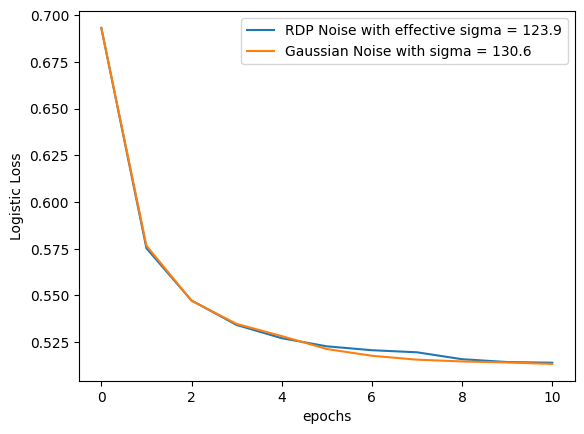

In [6]:
epochs_array = np.arange(epochs+1)
plt.plot(epochs_array, rdp_obj_per_epoch, label = f'RDP Noise with effective sigma = {rdp_sigma:0.4}')
plt.plot(epochs_array, gauss_obj_per_epoch, label = f'Gaussian Noise with sigma = {gaussian_sigma:0.4}')
plt.legend(); plt.xlabel("epochs"); plt.ylabel("Logistic Loss");

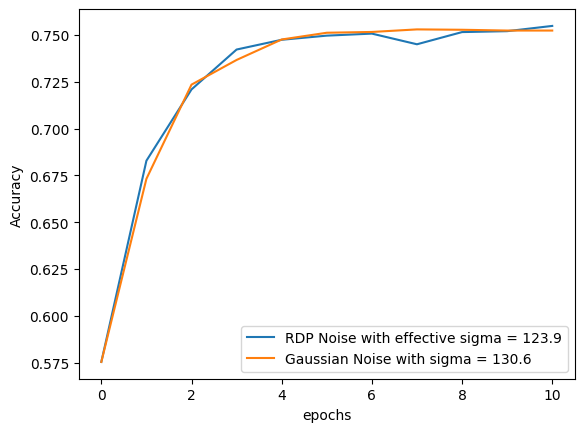

In [7]:
plt.plot(epochs_array, rdp_acc_per_epoch, label = f'RDP Noise with effective sigma = {rdp_sigma:0.4}')
plt.plot(epochs_array, gauss_acc_per_epoch, label = f'Gaussian Noise with sigma = {gaussian_sigma:0.4}')
plt.legend(); plt.xlabel("epochs"); plt.ylabel("Accuracy");

# AVERAGE LOGISTIC REGRESSION OVER RANDOM SEEDS

The cell block below runs the code over the a for loop with different seed values. 
The only thing that a user should change is the ```seeds``` list.

In [8]:
seeds = [42, 150, 3560, 550, 90]

parameter_lst_rdp = []; parameter_lst_gauss = []
objective_lst_rdp = []; objective_lst_gauss = []
accuracy_lst_rdp = []; accuracy_lst_gauss = []

for seed in seeds:

    #run algorithm
    w_rdp, rdp_obj_per_epoch, rdp_acc_per_epoch = run_jit_rdp_final(Loss, w_init, clip, \
            rdp_noise_params, learning_rate, epochs, seed, k)
    w_gauss, gauss_obj_per_epoch, gauss_acc_per_epoch = run_jit_gauss_final(Loss, w_init, clip, \
            gaussian_sigma_array, learning_rate, epochs, seed)

    #record results
    parameter_lst_rdp.append(w_rdp); parameter_lst_gauss.append(w_gauss)
    objective_lst_rdp.append(rdp_obj_per_epoch); objective_lst_gauss.append(gauss_obj_per_epoch)
    accuracy_lst_rdp.append(rdp_acc_per_epoch) ; accuracy_lst_gauss.append(gauss_acc_per_epoch)

#turn python lists into numpy arrays
parameter_lst_rdp = np.array(parameter_lst_rdp); parameter_lst_gauss = np.array(parameter_lst_gauss)
objective_lst_rdp = np.array(objective_lst_rdp); objective_lst_gauss = np.array(objective_lst_gauss)
accuracy_lst_rdp = np.array(accuracy_lst_rdp); accuracy_lst_gauss = np.array(accuracy_lst_gauss)

The code block below plots things. The ```plot_things``` function plots the average, the minimum, and the maximum values along an array.  For example, it plots the average, minimum, and maximum accuracy across seeds. The user should feel free to modify the plots as they see fit. 

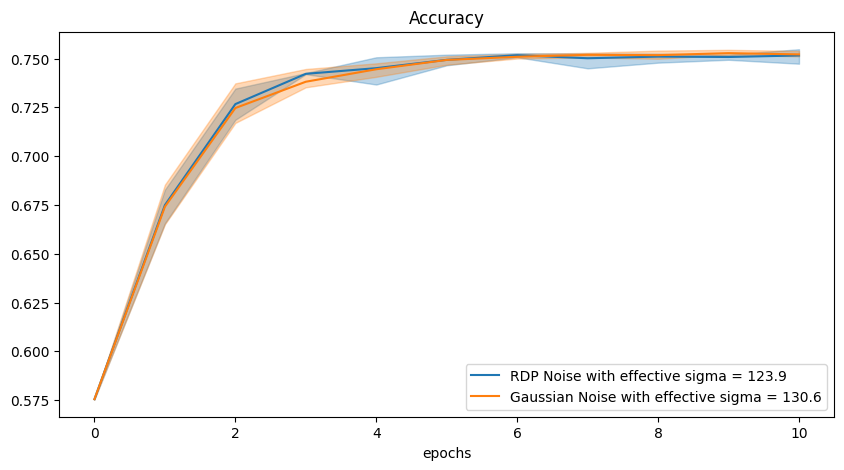

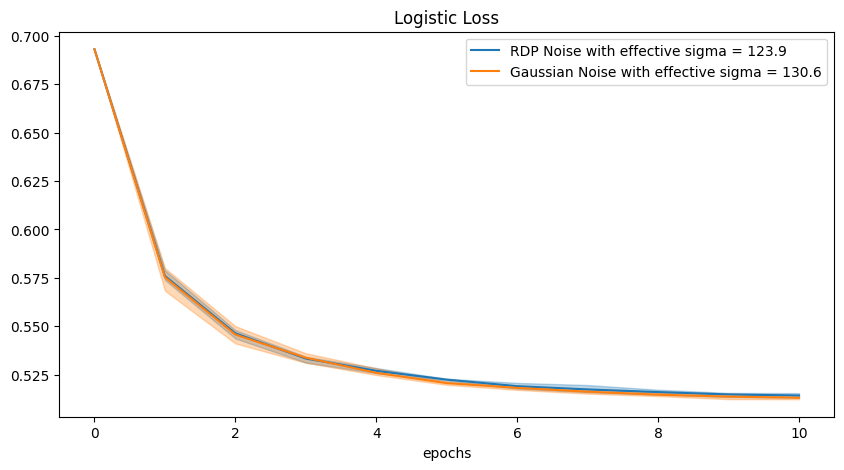

In [9]:
def plot_things(epochs_array, arr, name, sigma, color):

    mean_arr = np.mean(arr, axis = 0)
    mins = np.min(arr, axis = 0)
    maxs = np.max(arr, axis = 0)

    plot_label = f'{name} Noise with effective sigma = {sigma:0.4}'

        
    plt.plot(epochs_array, mean_arr, color = color, label = plot_label)
    plt.fill_between(epochs_array, mins, maxs, alpha=0.3, color=color)

plt.figure(figsize=(10, 5), dpi=100)
plot_things(epochs_array, accuracy_lst_rdp, name = 'RDP', sigma = rdp_sigma, color = 'C0')
plot_things(epochs_array, accuracy_lst_gauss, name = 'Gaussian', sigma = gaussian_sigma, color = 'C1')
plt.legend(); plt.xlabel("epochs"); plt.title('Accuracy'); plt.show()

plt.figure(figsize=(10, 5), dpi=100)
plot_things(epochs_array, objective_lst_rdp, name = 'RDP', sigma = rdp_sigma, color = 'C0')
plot_things(epochs_array, objective_lst_gauss, name = 'Gaussian', sigma = gaussian_sigma, color = 'C1')
plt.legend(); plt.xlabel("epochs"); plt.title('Logistic Loss'); plt.show()

# RUN LASSO ON NORMALIZED CALIFORNIA DATASET 

In [10]:
data = (X_california_norm, y_california_norm)
num_features = data[0].shape[1]

q = 1 # this is power of the cost function, i.e. C(x) = x^q
Cost = 98.86204187962656
k = 40 # 1/k is number of bins
N=15000
r = 0.9999
beta = 2

print(f"Number of bins used by the RDP optimization is {N}")
print(f"Size of each bin is {1/k}")
print(f"Range of the RDP optimization is (-{int(N/k)}, {int(N/k)})")

filename = rdp_dir + f"/noise_k{k}_N{N}_r{r}_cost{Cost}_q{q}_beta{2}.pkl"
rdp_noise_params, rho = get_RDP_stuff(filename) #grab the noise parameters and rho, i.e. Renyi Divergence
rdp_sigma = get_sigma_from_cost(Cost, q) #return the sigma of a mean-0 Gaussian RV X s.t. E[X^q] = Cost

gaussian_sigma = get_sigma_from_privacy(beta, rho) #return sigma of Gaussian mechanism s.t. it is (beta,rho)-RDP
gaussian_sigma_array = jnp.array([gaussian_sigma] * num_features) #the number of features in X

seed = 42
epochs = 10
hyperparams_prox = 0.1 #same as C++ code. Feel free to change 
w_init = jnp.zeros(num_features)
clip = 28.48035868435805 #same as C++ code. Feel free to change 
learning_rate = 1 #same as C++ code. Feel free to change 

    
Loss = Lasso_Loss(data, hyperparams_prox)

Number of bins used by the RDP optimization is 15000
Size of each bin is 0.025
Range of the RDP optimization is (-375, 375)


In [11]:
w_rdp, rdp_obj_per_epoch, rdp_acc_per_epoch = run_jit_rdp_final(Loss, w_init, clip, \
            rdp_noise_params, learning_rate, epochs, seed, k)

In [12]:
w_gauss, gauss_obj_per_epoch, gauss_acc_per_epoch = run_jit_gauss_final(Loss, w_init, clip, \
            gaussian_sigma_array, learning_rate, epochs, seed)

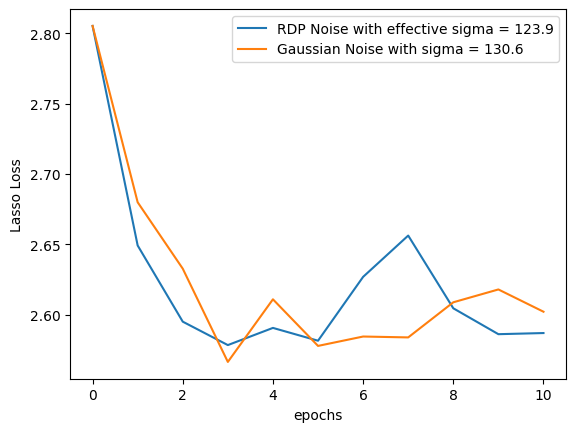

In [13]:
epochs_array = np.arange(epochs+1)
plt.plot(epochs_array, rdp_obj_per_epoch, label = f'RDP Noise with effective sigma = {rdp_sigma:0.4}')
plt.plot(epochs_array, gauss_obj_per_epoch, label = f'Gaussian Noise with sigma = {gaussian_sigma:0.4}')
plt.legend(); plt.xlabel("epochs"); plt.ylabel("Lasso Loss");

# AVERAGE LASSO OVER RANDOM SEEDS

In [14]:
seeds = [42, 150, 3560, 550, 90]

parameter_lst_rdp = []; parameter_lst_gauss = []
objective_lst_rdp = []; objective_lst_gauss = []
accuracy_lst_rdp = []; accuracy_lst_gauss = []

for seed in seeds:

    #run algorithm
    w_rdp, rdp_obj_per_epoch, rdp_acc_per_epoch = run_jit_rdp_final(Loss, w_init, clip, \
            rdp_noise_params, learning_rate, epochs, seed, k)
    w_gauss, gauss_obj_per_epoch, gauss_acc_per_epoch = run_jit_gauss_final(Loss, w_init, clip, \
            gaussian_sigma_array, learning_rate, epochs, seed)

    #record results
    parameter_lst_rdp.append(w_rdp); parameter_lst_gauss.append(w_gauss)
    objective_lst_rdp.append(rdp_obj_per_epoch); objective_lst_gauss.append(gauss_obj_per_epoch)
    accuracy_lst_rdp.append(rdp_acc_per_epoch) ; accuracy_lst_gauss.append(gauss_acc_per_epoch)

#turn python lists into numpy arrays
parameter_lst_rdp = np.array(parameter_lst_rdp); parameter_lst_gauss = np.array(parameter_lst_gauss)
objective_lst_rdp = np.array(objective_lst_rdp); objective_lst_gauss = np.array(objective_lst_gauss)
accuracy_lst_rdp = np.array(accuracy_lst_rdp); accuracy_lst_gauss = np.array(accuracy_lst_gauss)

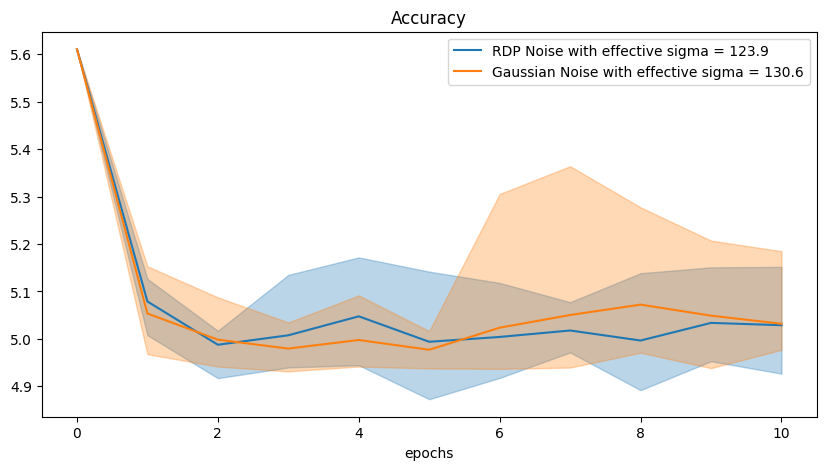

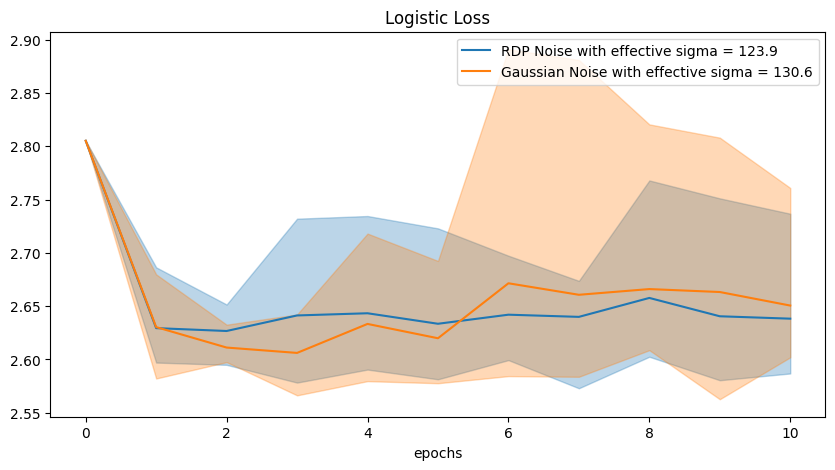

In [15]:
def plot_things(epochs_array, arr, name, sigma, color):

    mean_arr = np.mean(arr, axis = 0)
    mins = np.min(arr, axis = 0)
    maxs = np.max(arr, axis = 0)

    plot_label = f'{name} Noise with effective sigma = {sigma:0.4}'

        
    plt.plot(epochs_array, mean_arr, color = color, label = plot_label)
    plt.fill_between(epochs_array, mins, maxs, alpha=0.3, color=color)

plt.figure(figsize=(10, 5), dpi=100)
plot_things(epochs_array, accuracy_lst_rdp, name = 'RDP', sigma = rdp_sigma, color = 'C0')
plot_things(epochs_array, accuracy_lst_gauss, name = 'Gaussian', sigma = gaussian_sigma, color = 'C1')
plt.legend(); plt.xlabel("epochs"); plt.title('Accuracy'); plt.show()

plt.figure(figsize=(10, 5), dpi=100)
plot_things(epochs_array, objective_lst_rdp, name = 'RDP', sigma = rdp_sigma, color = 'C0')
plot_things(epochs_array, objective_lst_gauss, name = 'Gaussian', sigma = gaussian_sigma, color = 'C1')
plt.legend(); plt.xlabel("epochs"); plt.title('Logistic Loss'); plt.show()